In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from collections import defaultdict
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px
import math
import statistics as stats
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
from sklearn.neighbors import KernelDensity
from sklearn.metrics.cluster import mutual_info_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import DBSCAN

In [2]:
def plot_prob_density(new_vec, title=""):

   n = len(new_vec)
   Q1Q3 = np.quantile(new_vec, [0.25, 0.75])
   IQR = Q1Q3[1] - Q1Q3[0]
   sigma_hat = stats.variance(new_vec)


   # Silverman's rule of thumb
   h = 0.9 * min(np.sqrt(sigma_hat), IQR) / n ** (1 / 5)
   print(h)


   def K(r):
       return np.exp(-(r**2) / 2) / np.sqrt(2 * math.pi)


   def p(x, y):
       return K((x - y) / h)


   def f(x):


       my_sum = 0


       for x_i in new_vec:
           my_sum += p(x, x_i)


       return my_sum / (n * h)


   del_x = 0.1 * h
   D = np.arange(
       min(new_vec) - np.sqrt(sigma_hat), max(new_vec) + np.sqrt(sigma_hat), del_x
   )
   Y = np.array([f(x) for x in D])


   plt.figure(figsize=(15, 10))
   plt.plot(D, Y)
   if title != "":
       plt.title(title)
   plt.show()
  
   return D, Y


def plot_three_way_interaction(tx, ty, tz, xlabel = "x data", ylabel = "y data", zlabel = "z data", binwidth_x = 0.25, binwidth_y = 0.25, title = ""):


   fig = plt.figure(figsize=(12, 12))
   gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                       left=0.1, right=0.9, bottom=0.1, top=0.9,
                       wspace=0.05, hspace=0.05)
   # Create the Axes.
   ax0 = fig.add_subplot(gs[0, 1])
   ax = fig.add_subplot(gs[1, 0])
   ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
   ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)




   def scatter_hist_and_colorbar(x, y, c, ax, ax_histx, ax_histy,label):
       # no labels
       ax_histx.tick_params(axis="x", labelbottom=False)
       ax_histy.tick_params(axis="y", labelleft=False)


       # the scatter plot:
       sc=ax.scatter(x,y,marker='o',label=label,c=c)


       # now determine nice limits by hand:
       # binwidth = 0.25
      
       xlim_max = (int(np.max(x)/binwidth_x) + 1) * binwidth_x
       ylim_max = (int(np.max(y)/binwidth_y) + 1) * binwidth_y


       xlim_min = (int(np.min(x)/binwidth_x) + 1) * binwidth_x
       ylim_min = (int(np.min(y)/binwidth_y) + 1) * binwidth_y
          


       xbins = np.arange(xlim_min - binwidth_x, xlim_max + binwidth_x, binwidth_x)
       ybins = np.arange(ylim_min - binwidth_y, ylim_max + binwidth_y, binwidth_y)   
       ax_histx.hist(x, bins=xbins)
       ax_histy.hist(y, bins=ybins, orientation='horizontal')
      
       return sc
      
   sc1= scatter_hist_and_colorbar(tx,ty,tz, ax, ax_histx, ax_histy,label=zlabel)
   ax.set_ylabel(ylabel)
   ax.set_xlabel(xlabel)
   ax.legend()




   divider = make_axes_locatable(ax)




   divider = make_axes_locatable(ax0)
   ca = divider.append_axes('left', size='50%')
   ax0.axis('off')




   cbar=fig.colorbar(sc1, cax=ca, orientation='vertical')
   cbar.ax.set_ylabel(zlabel,rotation=270,labelpad=5)
   cbar.ax.yaxis.set_ticks_position("right")


   if len(title) > 0:
       ax_histx.set_title(title)


   gs.tight_layout(fig,pad=1)
   plt.savefig('example.png')
   plt.show()



In [3]:
time_series = pd.read_excel('artist_google_freq.xlsx', index_col=None)  

In [4]:
time_series

,Date,total,Artist
0,2005-01-01,0,Billy Joe & The Checkmates
1,2005-02-01,0,Billy Joe & The Checkmates
2,2005-03-01,0,Billy Joe & The Checkmates
3,2005-04-01,0,Billy Joe & The Checkmates
4,2005-05-01,0,Billy Joe & The Checkmates
...,...,...,...
775165,2024-11-01,2,Secondhand Serenade
775166,2024-12-01,2,Secondhand Serenade
775167,2025-01-01,2,Secondhand Serenade
775168,2025-02-01,2,Secondhand Serenade


In [5]:
billboard = pd.read_excel('billboard_information.xlsx', index_col=None)  

In [6]:
billboard

,Track Name,Artists,Genres,Duration (ms),Explicit,Popularity,Available Markets,Artist Country,Billboard Year
0,God's Plan,Drake,hip hop,198973,True,78,180,CA,2018
1,Perfect,Ed Sheeran,soft pop,263400,False,83,184,GB,2018
2,Meant to Be (feat. Florida Georgia Line),"Bebe Rexha, Florida Georgia Line","pop country, acoustic country, country",163870,False,66,178,"US, US",2018
3,Havana (feat. Young Thug),"Camila Cabello, Young Thug","trap, rap, pop, melodic rap",217306,False,76,185,"US, CA",2018
4,rockstar (feat. 21 Savage),"Post Malone, 21 Savage","hip hop, trap",218146,True,77,183,"US, US",2018
...,...,...,...,...,...,...,...,...,...
6579,I Saw Red,Warrant,"glam rock, glam metal",226866,False,12,182,US,1991
6580,Miles Away,Winger,"arena rock, hard rock, album rock, glam metal,...",255333,False,0,0,US,1991
6581,Do You Want Me,Salt-N-Pepa,hip hop,232266,False,33,184,US,1991
6582,The Motown Song (with The Temptations) - 2008 ...,"Rod Stewart, The Temptations","soft rock, soul, motown",238013,False,28,2,"GB, US",1991


In [7]:
merged = billboard.merge(time_series, left_on='Artists', right_on='Artist')

In [8]:
merged

,Track Name,Artists,Genres,Duration (ms),Explicit,Popularity,Available Markets,Artist Country,Billboard Year,Date,total,Artist
0,God's Plan,Drake,hip hop,198973,True,78,180,CA,2018,2005-01-01,18,Drake
1,God's Plan,Drake,hip hop,198973,True,78,180,CA,2018,2005-02-01,21,Drake
2,God's Plan,Drake,hip hop,198973,True,78,180,CA,2018,2005-03-01,17,Drake
3,God's Plan,Drake,hip hop,198973,True,78,180,CA,2018,2005-04-01,18,Drake
4,God's Plan,Drake,hip hop,198973,True,78,180,CA,2018,2005-05-01,15,Drake
...,...,...,...,...,...,...,...,...,...,...,...,...
1323373,Shiny Happy People,R.E.M.,"jangle pop, alternative rock, rock",224800,False,0,0,US,1991,2024-11-01,7,R.E.M.
1323374,Shiny Happy People,R.E.M.,"jangle pop, alternative rock, rock",224800,False,0,0,US,1991,2024-12-01,7,R.E.M.
1323375,Shiny Happy People,R.E.M.,"jangle pop, alternative rock, rock",224800,False,0,0,US,1991,2025-01-01,8,R.E.M.
1323376,Shiny Happy People,R.E.M.,"jangle pop, alternative rock, rock",224800,False,0,0,US,1991,2025-02-01,7,R.E.M.


In [9]:
# normalize time 
T = {}

index = 0
for year in range(2005, 2026): 
    for month in range(1, 13): 
        T[pd.Timestamp(str(year) + ' - ' + str(month) + ' - 1')] = index
        index += 1

In [10]:
y_1 = defaultdict(float) 
y_2 = defaultdict(float) 
y_3 = defaultdict(list)
X = defaultdict(list)

for stupid, row in merged.iterrows(): 
    curr_artist = row['Artist']
    X[curr_artist].append([row['Date'],row['total']])
    y_1[curr_artist] += row['total']
    y_2[curr_artist] = max(row['Popularity'], y_2[curr_artist])
    y_3[curr_artist].append(row['Billboard Year'])


In [11]:
num_t_steps = len(T.keys())

In [12]:
num_t_steps

252

In [13]:
Y_1 = []
Y_2 = []
Y_3 = []
X_0 = []
Y_4 = []
artist_name = []
error = 0
for key, values in X.items(): 
    curr_time_series = [0.0] * num_t_steps
    Y_1.append(y_1[key])
    Y_2.append(y_2[key])
    Y_3.append(len(set(y_3[key])))
    Y_4.append(2025 - min(y_3[key]))
    
    for t_i, val_i in values: 
        curr_time_series[T[t_i]] = val_i
    X_0.append(curr_time_series)
    artist_name.append(key)

Y_1 = np.array(Y_1) 
Y_2 = np.array(Y_2) 
Y_3 = np.array(Y_3)
Y_4 = np.array(Y_4)
X_0 = np.array(X_0)

In [14]:
curr_file = pd.DataFrame({'Artist': artist_name, 'Total Traffic': Y_1, 'Spotify Popularity': Y_2, 'Billboard Counts':Y_3, 'Traffic Since Breakout': Y_4})

In [15]:
curr_file.to_excel("useful_statistics.xlsx", index=False)

In [16]:
np.median(X_0.flatten())

np.float64(18.0)

In [47]:
X_reduced = X_0 >= 50
X_reduced = X_reduced.astype(int)

In [48]:
#X_reduced = normalize(X_0, axis=0)

In [49]:
X_reduced

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], shape=(2182, 252))

In [57]:
dbscan = DBSCAN(eps=3, min_samples=20)
Y_5 = dbscan.fit_predict(X_reduced)

In [58]:
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X_reduced)

In [59]:
X_embedded.shape

(2182, 3)

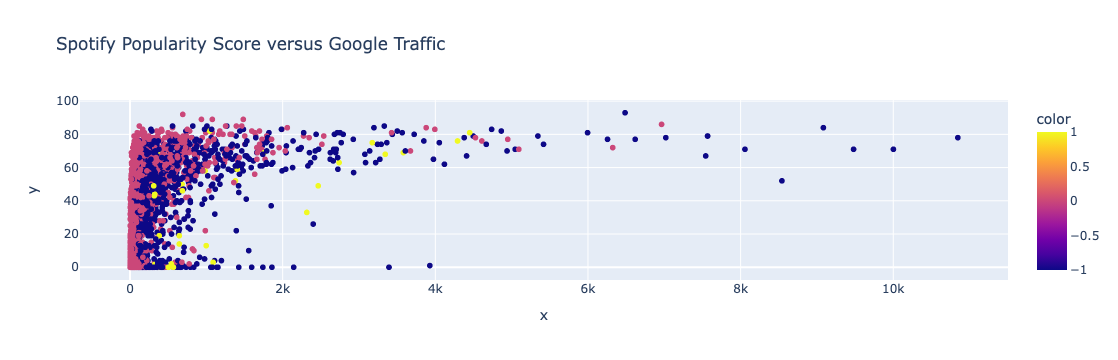

In [60]:
fig = px.scatter(x= np.divide(Y_1, Y_4), y= Y_2, hover_data=[artist_name], title="Spotify Popularity Score versus Google Traffic", color=Y_5)
fig.show()

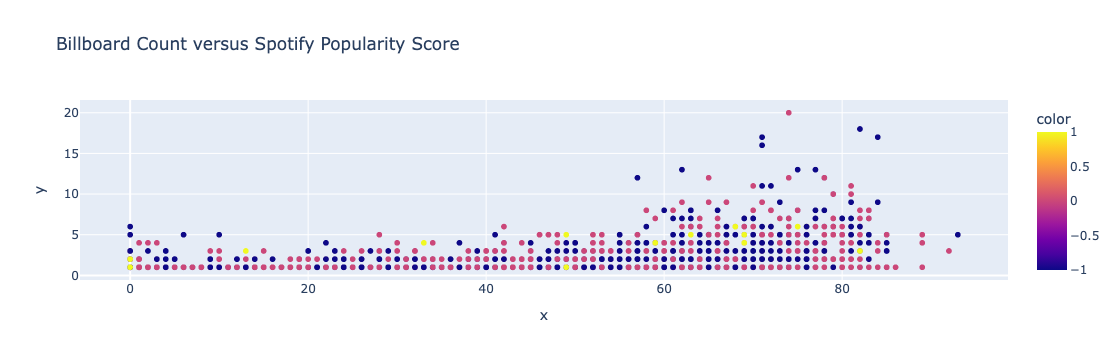

In [61]:
fig = px.scatter(x=Y_2, y=Y_3, hover_data=[artist_name], title="Billboard Count versus Spotify Popularity Score", color=Y_5)
fig.show()

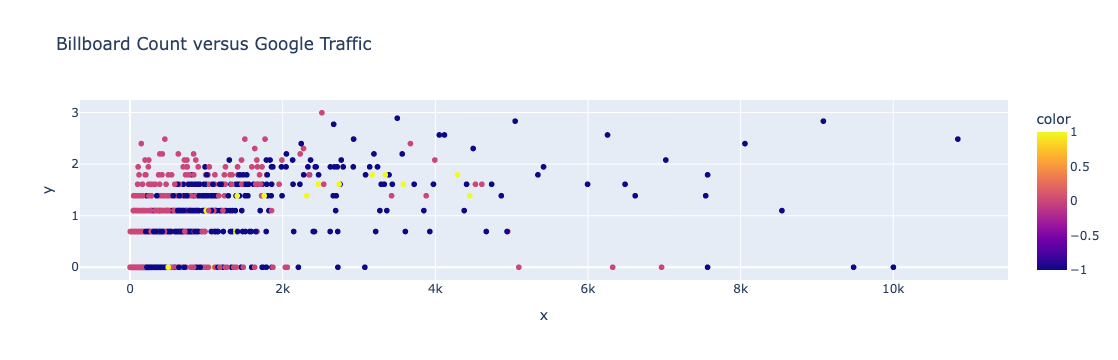

In [62]:
fig = px.scatter(x=np.divide(Y_1, Y_4), y=np.log(Y_3), hover_data=[artist_name], title="Billboard Count versus Google Traffic",color=Y_5)
fig.show()

In [76]:
things_to_plot = []

things_to_plot.append(
        go.Scatter3d(x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2],
            mode='markers',
            marker=dict(
                size=5,
                color=Y_5,                # set color to an array/list of desired values
                colorscale=[
                 "orange", "red", "green", "blue", "purple"],   # choose a colorscale
                opacity=1
                ), 
            hoverinfo='none',
            showlegend=False)
    )

layout = go.Layout(autosize=False, width=900, height=900, showlegend = False, scene=dict(
                 aspectmode='data'
         ))
fig = go.Figure(data = things_to_plot, layout = layout)
iplot(fig)

In [77]:
set(Y_5)

{np.int64(-1), np.int64(0), np.int64(1)}

In [78]:
for cluster in range(-1,2): 
    conditional_probaility = Y_5 == cluster
    for k, statistic in enumerate([Y_1, Y_2, Y_3, Y_4]):
        print(k)
        print("min", np.min(statistic[conditional_probaility]))
        print("median", np.median(statistic[conditional_probaility]))
        print("max", np.max(statistic[conditional_probaility]))


0
min 923.0
median 13292.0
max 222885.0
1
min 0
median 52.0
max 93
2
min 1
median 1.0
max 18
3
min 1
median 45.0
max 66
0
min 100.0
median 4396.0
max 150024.0
1
min 0
median 48.0
max 92
2
min 1
median 1.0
max 20
3
min 1
median 41.0
max 66
0
min 15144.0
median 26500.0
max 183920.0
1
min 0
median 47.5
max 82
2
min 1
median 1.0
max 6
3
min 14
median 46.5
max 57


In [81]:
unique, counts = np.unique(Y_5, return_counts=True)

In [82]:
dict(zip(unique, counts))

{np.int64(-1): np.int64(893),
 np.int64(0): np.int64(1253),
 np.int64(1): np.int64(36)}

In [105]:
search_list = []
for k, artist in enumerate(artist_name): 
    if Y_5[k] == -1: 
        print(artist)
        search_list.append(artist) 


Drake
Post Malone
Dua Lipa
Camila Cabello
Ariana Grande
Imagine Dragons
Taylor Swift
Halsey
NF
Dan + Shay
Portugal. The Man
Selena Gomez
Shawn Mendes
Kane Brown
Cardi B
Maroon 5
Charlie Puth
Khalid
Thomas Rhett
The Weeknd
Florida Georgia Line
YoungBoy Never Broke Again
Daddy Yankee
Brett Young
Luke Combs
Mario
Lifehouse
Black Eyed Peas
The Killers
Rihanna
Papa Roach
Fall Out Boy
Nickelback
Akon
Eminem
T.I.
Destiny's Child
Natalie
Carrie Underwood
Fantasia
Ludacris
Natasha Bedingfield
Jennifer Lopez
T-Pain
112
Lady A
Train
Jason Derulo
Katy Perry
Bruno Mars
The Script
Michael Bublé
Flo Rida
OneRepublic
Neon Trees
Nicki Minaj
Sugarland
Beyoncé
Kings of Leon
Paramore
Sara Bareilles
Jerrod Niemann
Future
Niall Horan
Justin Timberlake
Twenty One Pilots
Aminé
P!nk
Harry Styles
Dustin Lynch
blackbear
The Calling
Puddle Of Mudd
Creed
Enrique Iglesias
Default
No Doubt
Brandy
Ginuwine
Jewel
George Strait
Alanis Morissette
Christina Aguilera
Wayne Wonder
Monica
Lumidee
Jason Mraz
Shania Twain
Nas

In [106]:
"Chappell Roan" in search_list

False

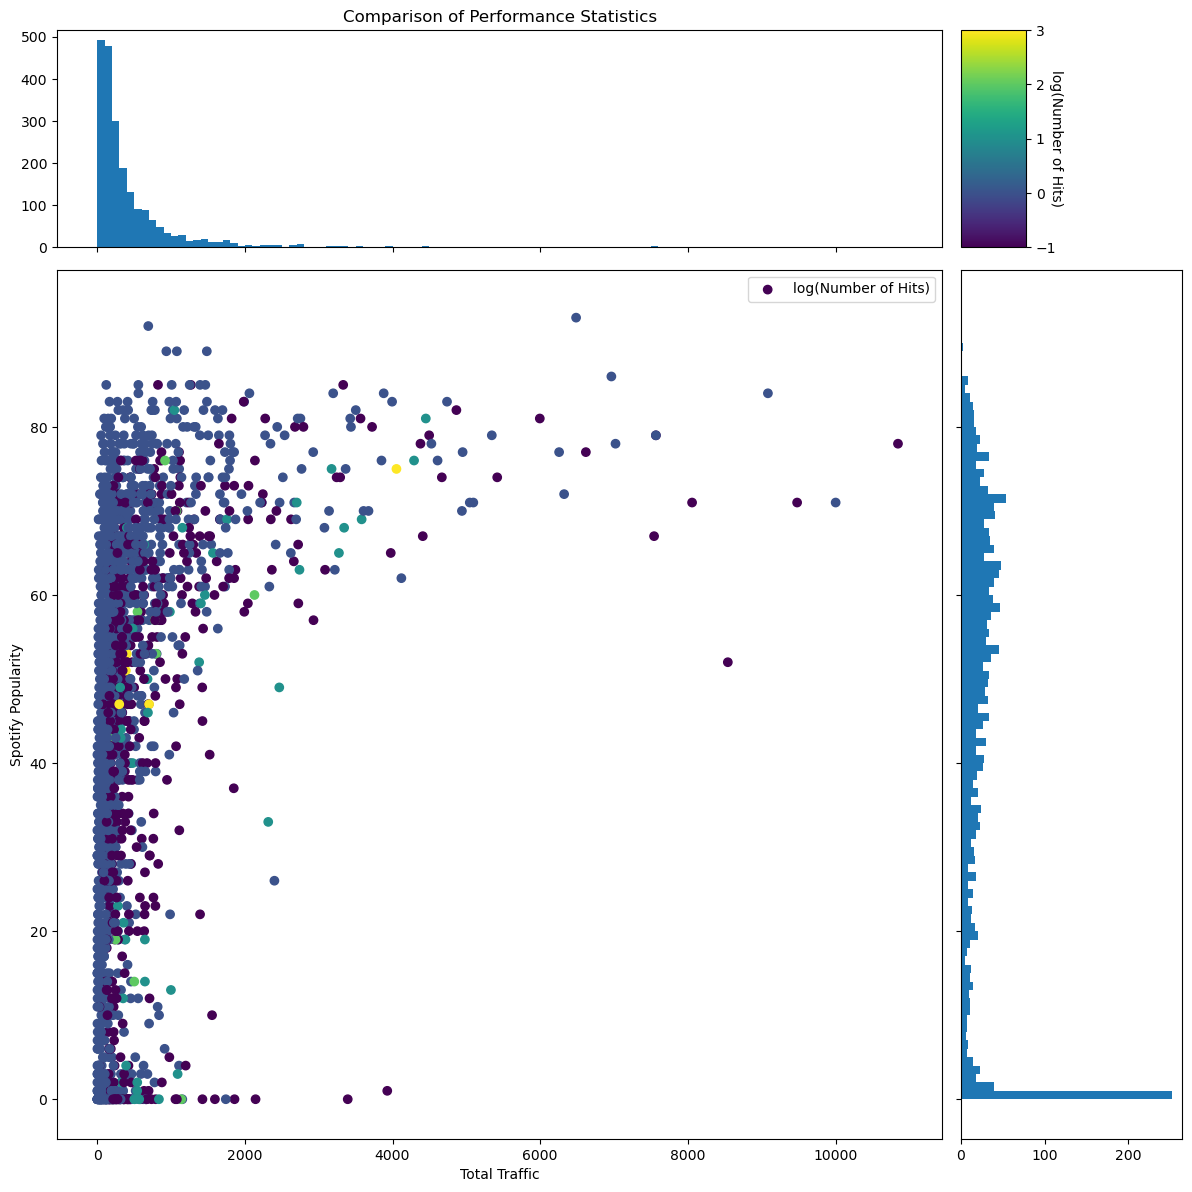

In [30]:
plot_three_way_interaction(np.divide(Y_1, Y_4), Y_2, Y_5, xlabel = "Total Traffic", ylabel = "Spotify Popularity", zlabel = "log(Number of Hits)", binwidth_x = 100, binwidth_y = 1, title = "Comparison of Performance Statistics")